In [1]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt
from matplotlib import dates as mlp_dates
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re
from collections import defaultdict
lemmatizer = WordNetLemmatizer() 

In [2]:
data = pd.read_csv('data.csv')
demos = pd.read_csv('demos_data.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 16 columns):
id                              252 non-null int64
ad_creation_time                252 non-null object
ad_creative_body                249 non-null object
ad_creative_link_caption        131 non-null object
ad_creative_link_description    90 non-null object
ad_creative_link_title          168 non-null object
ad_delivery_start_time          252 non-null object
ad_delivery_stop_time           249 non-null object
ad_snapshot_url                 252 non-null object
currency                        252 non-null object
funding_entity                  250 non-null object
page_id                         252 non-null int64
page_name                       252 non-null object
impression_range                252 non-null object
spend_range                     252 non-null object
platforms                       252 non-null object
dtypes: int64(2), object(14)
memory usage: 31.6+ KB


In [4]:
data.head(3)

,id,ad_creation_time,ad_creative_body,ad_creative_link_caption,ad_creative_link_description,ad_creative_link_title,ad_delivery_start_time,ad_delivery_stop_time,ad_snapshot_url,currency,funding_entity,page_id,page_name,impression_range,spend_range,platforms
0,499844334269818,2019-12-11T13:54:18+0000,Every vote counts - Vote DODDS X,NaN,NaN,NaN,2019-12-12T00:01:59+0000,2019-12-12T21:59:59+0000,https://www.facebook.com/ads/archive/render_ad...,GBP,Democratic Unionist Party,105732052794210,Democratic Unionist Party,"3000,3999","0,99","facebook,instagram"
1,453850975333442,2019-12-10T16:36:40+0000,The DUP is the only party with a positive plan...,www.mydup.com,NaN,The DUP has a positive plan for NI,2019-12-10T16:36:40+0000,2019-12-12T16:36:29+0000,https://www.facebook.com/ads/archive/render_ad...,GBP,Democratic Unionist Party,105732052794210,Democratic Unionist Party,"25000,29999","200,299","facebook,instagram"
2,442557686431595,2019-12-10T16:23:32+0000,A vote for the DUP is a vote to get Northern I...,www.mydup.com,NaN,Vote to get NI moving again,2019-12-10T16:23:32+0000,2019-12-12T16:23:20+0000,https://www.facebook.com/ads/archive/render_ad...,GBP,Democratic Unionist Party,105732052794210,Democratic Unionist Party,"15000,19999","100,199","facebook,instagram"


## Pre Processing
1. Parse ad_delivery_start_time to datetime
2. Filter data on election timeline 
3. Filter out demographic data on under 18s
4. Impression & Spend features converted to numeric & average taken of their range 

In [5]:
data['ad_date'] = pd.to_datetime(data.ad_delivery_start_time.str.slice(start=0, stop=10))

In [6]:
data = data[(data['ad_date'] > '2019-11-06') & (data['ad_date'] < '2019-12-12')]

In [7]:
demos = demos.loc[demos['age'] != '13-17']

In [8]:
spend_range = [[int(range_[0]), int(range_[1])] for range_ in data.spend_range.str.split(',')]
data['spend'] = list(map(lambda x: sum(x)/2, spend_range))
impression_range = [[int(range_[0]), int(range_[1])] for range_ in data.impression_range.str.split(',')]
data['impressions'] = list(map(lambda x: sum(x)/2, impression_range))

## Analysis

#### What was the cumulative spend by party and what did they pay for?

In [9]:
plot1_data = data.groupby(['ad_date', 'page_name'])['spend', 'impressions'].sum()\
.groupby('page_name').cumsum().reset_index().melt(id_vars=['ad_date', 'page_name'])

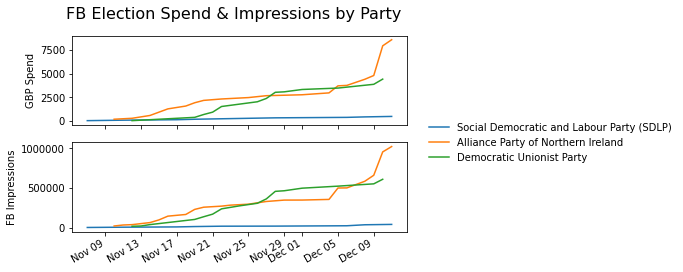

In [10]:
fig, ax = plt.subplots(2,1, sharex=True)
fig.suptitle('FB Election Spend & Impressions by Party', fontsize=16)
ax1 = sns.lineplot(data=plot1_data[plot1_data['variable']=='spend'], x='ad_date', y='value', 
                   hue='page_name', legend=False, ax=ax[0])
ax2 = sns.lineplot(data=plot1_data[plot1_data['variable']=='impressions'], x='ad_date', y='value', 
                   hue='page_name', legend='brief', ax=ax[1])
ax2.set_xlabel('')
ax2.set_ylabel('FB Impressions')
ax1.set_ylabel('GBP Spend')
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(bbox_to_anchor=(1.04,1), loc="center left", frameon=False, handles=handles[1:], labels=labels[1:])
ax2.ticklabel_format(useOffset=False, axis='y', style='plain')
fig.autofmt_xdate()
ax2.xaxis.set_major_formatter(mlp_dates.DateFormatter('%b %d'))

* Everytime a user is presented with an advertisment facebook register an impression.
* Unsurprisingly there is a near perfect correlation between spend and impressions.
* Alliance out ahead on advertising with SDLP doing next to nothing.

#### What was the aggregate demographic distribution targed by each campaign?

In [11]:
demographics = demos.merge(right=data[['id', 'impressions', 'page_name']])
demographics['impress_per_demo'] = demographics.percentage * demographics.impressions
plot2_data = demographics.groupby(['age', 'page_name'], as_index=False)['impress_per_demo'].sum().set_index('page_name')

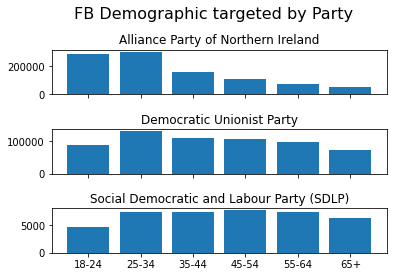

In [12]:
fig, axes = plt.subplots(3,1, sharex=True)
fig.suptitle('FB Demographic targeted by Party', fontsize=16)
fig.subplots_adjust(hspace=0.78, top=0.83) 
partys = plot2_data.index.unique()
for party, ax in zip(partys, axes):
    subplot_data = plot2_data.loc[party]
    ax.bar(x=subplot_data['age'], height=subplot_data['impress_per_demo'])
    ax.set_title(party)

* Note Y axis varies for each subplot to show the targeted distribution proportional to each campaign.
* Alliance advertising is heavily skewed to younger voters which fits in with their anti-brexit message

#### What was the campaign message?

In [13]:
stop_words = set(stopwords.words('english')) 
stop_words.add('vote')  
stop_words.add('voting') 

In [14]:
def preprocess_text(text):
    text = str(text)
    text = re.sub(r'[^a-zA-z\s]', '', text) # Remove special characters
    text = text.lower() # To lower case
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()]) # Lemmatizatise words
    text = ' '.join([word for word in text.split() if word not in stop_words]) # Remove stop words
    return text
data.dropna(subset=['ad_creative_body'], inplace=True) # Three Alliance ads with no body, removed
data['body'] = data.ad_creative_body.apply(preprocess_text) 

In [15]:
# Remove outlier ads with over 300 characters in their body, inclusion will skew wordcloud
plot3_data = data.copy()
plot3_data = plot3_data[plot3_data.body.str.len() < 300]

In [16]:
results = []
parties = plot3_data.page_name.unique()
for party in parties:
    party_data = plot3_data[plot3_data['page_name'] == party]
    word_count_container = defaultdict(int)
    for index, ad_body in party_data.body.iteritems():
        for word in ad_body.split():
            word_count_container[word] += 1 * party_data.impressions[index]
    results.append([word_count_container, party])

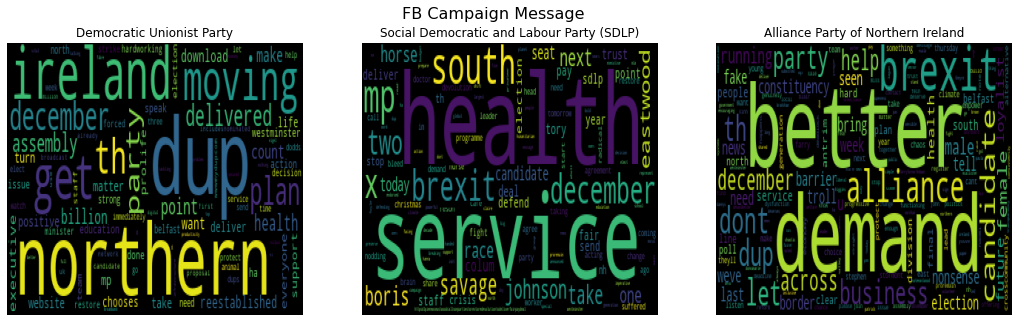

In [17]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(18, 5))
fig.suptitle('FB Campaign Message', fontsize=16)
for i in range(3):
    ax[i].imshow(WordCloud().generate_from_frequencies(results[i][0]), aspect='auto')
    ax[i].set_title(results[i][1])
    ax[i].axis('off')
plt.show()

* SDLP seems to have modelled their FB campaign around the NHS while Alliance had a tag line 'Demand Better'.
* 'Get' & 'Moving' from the DUP suggest the message was about breaking the political deadlock.

#### Was the campaign message different for older/younger voters?

In [18]:
plot4_data = demos.copy()
plot4_data['over_35'] = plot4_data.age.apply(lambda x: ' Under 35' if x in ['18-24', '25-34'] else ' Over 35')
plot4_data = plot4_data.groupby(['id', 'over_35'], as_index=False)['percentage'].sum().\
merge(data[['id', 'page_name', 'body', 'impressions']])
plot4_data['party_demos'] = plot4_data.page_name + plot4_data.over_35.astype('str')

In [19]:
results = []
parties = plot4_data.party_demos.unique()
for party in parties:
    party_data = plot4_data[plot4_data['party_demos'] == party]
    word_count_container = defaultdict(int)
    for index, ad_body in party_data.body.iteritems():
        for word in ad_body.split():
            word_count_container[word] += 1 * party_data.impressions[index]
    results.append([word_count_container, party])

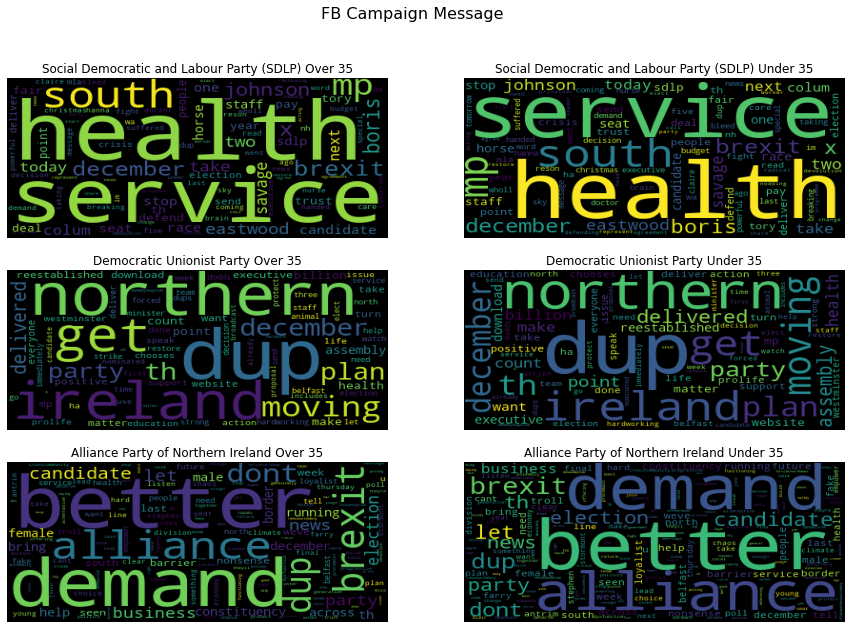

In [20]:
fig, ax = plt.subplots(3, 2, sharey=True, figsize=(15, 10))
fig.suptitle('FB Campaign Message', fontsize=16)
i = 0
for row_axis in ax:
    for individual_axis in row_axis:  
        individual_axis.imshow(WordCloud().generate_from_frequencies(results[i][0]), aspect='auto')
        individual_axis.set_title(results[i][1])
        individual_axis.axis('off')
        i += 1
plt.show()

* Main message seems consistent across age bands